In [1]:
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import json
import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


In [2]:
DATA_DIR = Path("datasets")
MODULE = "BBB"
PRESENTATIONS = ["2013B", "2013J"]

CUTOFF = 7                  # ✅ Snapshot ngày 7 (tính từ ngày đăng ký)
WINDOW_DAYS = 7             # window ngắn đúng mốc cảnh báo
VAR_THRESH = 0.0
RANDOM_STATE = 42

MODEL_PATH = "early_dropout_7d_model.pkl"
THRESH_PATH = "early_dropout_7d_threshold.json"

TARGET_RECALL = 0.80        # ✅ chọn threshold sao cho recall >= 0.80

logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")


def load_raw(data_dir: Path) -> Dict[str, pd.DataFrame]:
    raw = {
        "student_info": pd.read_csv(data_dir / "studentInfo.csv"),
        "student_reg": pd.read_csv(data_dir / "studentRegistration.csv"),
        "student_vle": pd.read_csv(data_dir / "studentVle.csv"),
        "student_ass": pd.read_csv(data_dir / "studentAssessment.csv"),
        "assessments": pd.read_csv(data_dir / "assessments.csv"),
    }
    return raw


def prepare_students(
    raw: Dict[str, pd.DataFrame], module: str, presentations: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Registration scope
    reg_mod = raw["student_reg"].loc[
        (raw["student_reg"]["code_module"] == module)
        & (raw["student_reg"]["code_presentation"].isin(presentations)),
        ["id_student", "date_registration"],
    ].drop_duplicates()

    # Labels
    students = raw["student_info"].loc[
        (raw["student_info"]["code_module"] == module)
        & (raw["student_info"]["code_presentation"].isin(presentations))
        & (raw["student_info"]["id_student"].isin(reg_mod["id_student"])),
        ["id_student", "final_result"],
    ].copy()

    students["dropout"] = (students["final_result"] == "Withdrawn").astype(int)
    students = students[["id_student", "dropout"]].drop_duplicates()

    # VLE -> relative day
    vle_mod = raw["student_vle"].loc[
        (raw["student_vle"]["code_module"] == module)
        & (raw["student_vle"]["code_presentation"].isin(presentations)),
        ["id_student", "date", "sum_click"],
    ].merge(reg_mod, on="id_student", how="inner")

    vle_mod["date"] = pd.to_numeric(vle_mod["date"], errors="coerce")
    vle_mod["date_registration"] = pd.to_numeric(vle_mod["date_registration"], errors="coerce")
    vle_mod["sum_click"] = pd.to_numeric(vle_mod["sum_click"], errors="coerce").fillna(0)

    vle_mod["days_since_reg"] = vle_mod["date"] - vle_mod["date_registration"]
    vle_mod = vle_mod.loc[
        vle_mod["days_since_reg"].notna()
        & (vle_mod["days_since_reg"] >= 0)
    ].copy()
    vle_mod["days_since_reg"] = vle_mod["days_since_reg"].astype(int)

    # Assessments -> relative day (optional)
    ass_mod = raw["student_ass"].loc[:, ["id_student", "id_assessment", "date_submitted", "score"]]\
        .merge(reg_mod, on="id_student", how="inner")

    ass_mod["date_submitted"] = pd.to_numeric(ass_mod["date_submitted"], errors="coerce")
    ass_mod["date_registration"] = pd.to_numeric(ass_mod["date_registration"], errors="coerce")
    ass_mod["score"] = pd.to_numeric(ass_mod["score"], errors="coerce")

    ass_mod["days_since_reg"] = ass_mod["date_submitted"] - ass_mod["date_registration"]
    ass_mod = ass_mod.loc[
        ass_mod["date_submitted"].notna()
        & ass_mod["days_since_reg"].notna()
        & (ass_mod["days_since_reg"] >= 0)
    ].copy()
    ass_mod["days_since_reg"] = ass_mod["days_since_reg"].astype(int)

    logging.info("So hoc vien hop le: %d", students["id_student"].nunique())
    return students, vle_mod, ass_mod, raw["assessments"]


raw = load_raw(DATA_DIR)
students, vle_mod, ass_mod, assessments = prepare_students(raw, MODULE, PRESENTATIONS)

students.head()

[2025-12-27 10:37:14,998] INFO - So hoc vien hop le: 3960


,id_student,dropout
748,23629,0
749,25107,0
750,27891,1
751,29144,0
752,31663,0


In [3]:
def _safe_div(a: pd.Series, b: pd.Series, fill: float = 0.0) -> pd.Series:
    out = a / b.replace(0, np.nan)
    return out.fillna(fill)

def compute_inactivity_streak(active_days: List[int], start_day: int, end_day: int) -> int:
    """Số ngày không hoạt động liên tiếp ở phần đuôi của [start_day..end_day]"""
    if not active_days:
        return end_day - start_day + 1
    active = set(active_days)
    streak = 0
    d = end_day
    while d >= start_day and d not in active:
        streak += 1
        d -= 1
    return streak

def build_features_7d(
    students: pd.DataFrame,
    vle_mod: pd.DataFrame,
    cutoff: int = 7,
    window_days: int = 7,
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Build features ONLY for snapshot at cutoff=7 (days_since_reg <= 7).
    """
    start_day = 0
    end_day = cutoff
    n_days = cutoff + 1  # ✅ 0..7 => 8 ngày

    # keep activity within [0..7]
    vle_7 = vle_mod.loc[(vle_mod["days_since_reg"] >= start_day) & (vle_mod["days_since_reg"] <= end_day)].copy()

    # cumulative aggregates in 0..7
    agg = (vle_7.groupby("id_student", as_index=False)
           .agg(
               total_clicks=("sum_click", "sum"),
               active_days_total=("days_since_reg", "nunique"),
               last_active=("days_since_reg", "max"),
           ))

    agg["days_elapsed_since_reg"] = n_days
    agg["clicks_per_day_total"] = agg["total_clicks"] / n_days
    agg["active_ratio_total"] = agg["active_days_total"] / n_days
    agg["days_since_last_active"] = end_day - agg["last_active"]
    agg["avg_clicks_per_active_day_total"] = _safe_div(agg["total_clicks"], agg["active_days_total"], fill=0.0)

    # last 3 days clicks (cutoff-2..cutoff)
    start3 = max(0, end_day - 2)
    clicks_last_3 = (vle_7.loc[vle_7["days_since_reg"] >= start3]
                     .groupby("id_student")["sum_click"].sum()
                     .rename("clicks_last_3_days").reset_index())

    # split 0..3 vs 4..7 (proxy trend early-week)
    clicks_0_3 = (vle_7.loc[vle_7["days_since_reg"] <= 3]
                  .groupby("id_student")["sum_click"].sum()
                  .rename("clicks_0_3").reset_index())
    clicks_4_7 = (vle_7.loc[vle_7["days_since_reg"] >= 4]
                  .groupby("id_student")["sum_click"].sum()
                  .rename("clicks_4_7").reset_index())

    # inactivity streak in 0..7
    days_list = (vle_7.groupby("id_student")["days_since_reg"]
                 .apply(lambda x: sorted(x.unique().tolist()))
                 .rename("active_days_list")
                 .reset_index())
    days_list["inactivity_streak_7"] = days_list["active_days_list"].apply(
        lambda lst: compute_inactivity_streak(lst, start_day, end_day)
    )
    streak = days_list[["id_student", "inactivity_streak_7"]]

    # merge
    df = students.merge(agg, on="id_student", how="left")
    df = df.merge(clicks_last_3, on="id_student", how="left")
    df = df.merge(clicks_0_3, on="id_student", how="left")
    df = df.merge(clicks_4_7, on="id_student", how="left")
    df = df.merge(streak, on="id_student", how="left")

    # fill missing
    fill0 = [
        "total_clicks", "active_days_total", "last_active",
        "clicks_per_day_total", "active_ratio_total",
        "days_since_last_active", "avg_clicks_per_active_day_total",
        "clicks_last_3_days", "clicks_0_3", "clicks_4_7",
        "inactivity_streak_7"
    ]
    for c in fill0:
        df[c] = df[c].fillna(0)

    # derived
    df["trend_click_7"] = df["clicks_4_7"] - df["clicks_0_3"]
    df["ratio_click_7"] = (df["clicks_4_7"] + 1) / (df["clicks_0_3"] + 1)

    feature_cols = [
        "days_elapsed_since_reg",
        "clicks_per_day_total",
        "active_ratio_total",
        "avg_clicks_per_active_day_total",
        "days_since_last_active",
        "clicks_last_3_days",
        "clicks_0_3",
        "clicks_4_7",
        "trend_click_7",
        "ratio_click_7",
        "inactivity_streak_7",
    ]
    return df, feature_cols


final_df, feature_cols = build_features_7d(students, vle_mod, cutoff=CUTOFF, window_days=WINDOW_DAYS)

X = final_df[feature_cols].copy()
y = final_df["dropout"].astype(int)
groups = final_df["id_student"]

final_df.head()

,id_student,dropout,total_clicks,active_days_total,last_active,days_elapsed_since_reg,clicks_per_day_total,active_ratio_total,days_since_last_active,avg_clicks_per_active_day_total,clicks_last_3_days,clicks_0_3,clicks_4_7,inactivity_streak_7,trend_click_7,ratio_click_7
0,23629,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,25107,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,27891,1,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,29144,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,31663,0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
MODELS = {
    "RandomForest": RandomForestClassifier(
        n_estimators=400,
        max_depth=12,
        min_samples_leaf=5,
        min_samples_split=10,
        n_jobs=-1,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.03,
        loss="exponential",
        max_depth=3,
        min_samples_leaf=40,
        min_samples_split=20,
        n_estimators=150,
        random_state=RANDOM_STATE
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        learning_rate_init=0.01,
        alpha=0.0005,
        early_stopping=True,
        max_iter=800,
        random_state=RANDOM_STATE
    ),
    "LogReg": LogisticRegression(
        penalty="l1",
        solver="saga",
        max_iter=4000,
        random_state=RANDOM_STATE
    ),
}

def make_pipe(model_name: str, model):
    """
    - Tree models: NO SMOTE (thường ổn hơn), dùng class_weight
    - LR/MLP: có thể dùng SMOTE để tăng recall (đúng bài cảnh báo)
    """
    base_steps = [
        ("variance_threshold", VarianceThreshold(VAR_THRESH)),
        ("power_transformer", PowerTransformer()),
        ("classifier", model),
    ]

    if model_name in ["LogReg", "MLP"]:
        return ImbPipeline(steps=[
            ("variance_threshold", VarianceThreshold(VAR_THRESH)),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("power_transformer", PowerTransformer()),
            ("classifier", model),
        ])
    else:
        return SkPipeline(steps=base_steps)


cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []
best = {
    "model": None,
    "oof_proba": None,
    "oof_y": None,
    "score": -1  # dùng AP để chọn (hợp bài toán mất cân bằng)
}

for name, model in MODELS.items():
    oof_proba = np.zeros(len(X), dtype=float)
    oof_pred  = np.zeros(len(X), dtype=int)

    fold_metrics = []

    for fold, (tr_idx, te_idx) in enumerate(cv.split(X, y, groups), start=1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pipe = make_pipe(name, model)
        pipe.fit(X_tr, y_tr)

        proba = pipe.predict_proba(X_te)[:, 1]
        pred = (proba >= 0.5).astype(int)

        oof_proba[te_idx] = proba
        oof_pred[te_idx] = pred

        fold_metrics.append({
            "fold": fold,
            "acc": accuracy_score(y_te, pred),
            "precision": precision_score(y_te, pred, zero_division=0),
            "recall": recall_score(y_te, pred),
            "f1": f1_score(y_te, pred, zero_division=0),
            "auc": roc_auc_score(y_te, proba),
            "ap": average_precision_score(y_te, proba),
        })

    m = pd.DataFrame(fold_metrics).mean(numeric_only=True).to_dict()
    m["model"] = name
    rows.append(m)

    # chọn best theo AP (ổn cho imbalance)
    ap_all = average_precision_score(y.values, oof_proba)
    if ap_all > best["score"]:
        best = {"model": name, "oof_proba": oof_proba, "oof_y": y.values, "score": ap_all}

summary_df = pd.DataFrame(rows).sort_values("ap", ascending=False)
display(summary_df)

print("Best model (by AP):", best["model"], "| OOF AP:", best["score"])

/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of

,fold,acc,precision,recall,f1,auc,ap,model
0,3.0,0.309256,0.288478,0.977030,0.445432,0.509790,0.288413,RandomForest
1,3.0,0.716078,0.000000,0.000000,0.000000,0.509117,0.288265,GradientBoosting
3,3.0,0.306498,0.287873,0.978796,0.444892,0.506526,0.287754,LogReg
2,3.0,0.385441,0.254499,0.781439,0.356406,0.502247,0.286691,MLP


Best model (by AP): RandomForest | OOF AP: 0.2869654353578257


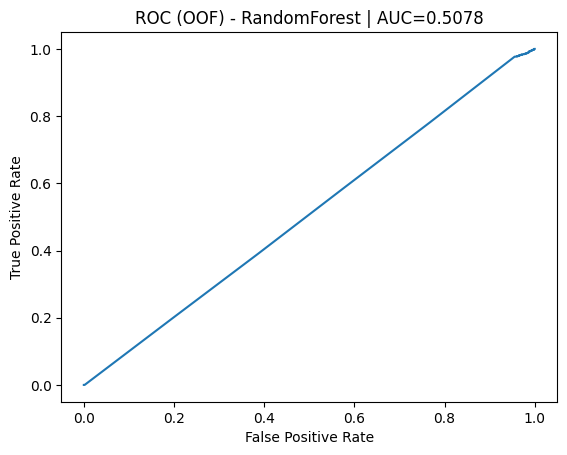

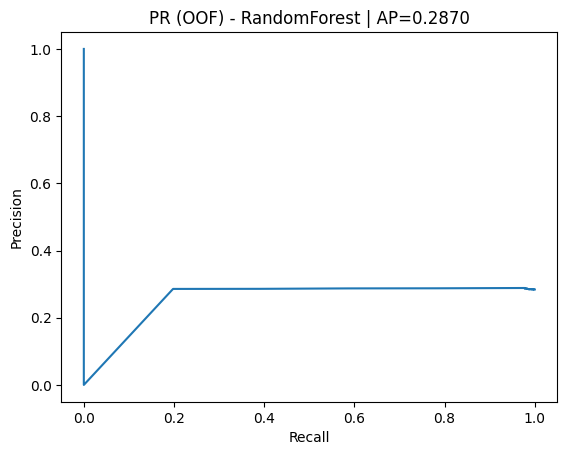

In [5]:
y_true = best["oof_y"]
y_score = best["oof_proba"]

# ROC
fpr, tpr, roc_thr = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr)
plt.title(f"ROC (OOF) - {best['model']} | AUC={roc_auc_score(y_true, y_score):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# PR
prec, rec, pr_thr = precision_recall_curve(y_true, y_score)
plt.figure()
plt.plot(rec, prec)
plt.title(f"PR (OOF) - {best['model']} | AP={average_precision_score(y_true, y_score):.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [6]:
# ---- chọn threshold: recall >= TARGET_RECALL, precision cao nhất ----
# lưu ý: pr_thr có length = len(prec)-1
valid = np.where(rec[:-1] >= TARGET_RECALL)[0]  # bỏ phần tử cuối để khớp pr_thr
if len(valid) == 0:
    # fallback: lấy threshold max F1
    f1s = 2 * prec * rec / (prec + rec + 1e-9)
    best_idx = np.argmax(f1s[:-1])
    chosen_thr = pr_thr[best_idx]
    rule = f"Fallback max-F1 (no threshold reaches recall>={TARGET_RECALL})"
else:
    best_idx = valid[np.argmax(prec[valid])]
    chosen_thr = pr_thr[best_idx]
    rule = f"Max precision subject to recall>={TARGET_RECALL}"

print("Chosen threshold:", float(chosen_thr))
print("Selection rule:", rule)

# metric tại threshold đã chọn
pred_chosen = (y_score >= chosen_thr).astype(int)
print("OOF Precision:", precision_score(y_true, pred_chosen, zero_division=0))
print("OOF Recall   :", recall_score(y_true, pred_chosen))
print("OOF F1       :", f1_score(y_true, pred_chosen, zero_division=0))
print("OOF AUC      :", roc_auc_score(y_true, y_score))
print("OOF AP       :", average_precision_score(y_true, y_score))


best_model = MODELS[best["model"]]
final_pipe = make_pipe(best["model"], best_model)
final_pipe.fit(X, y)

joblib.dump(final_pipe, MODEL_PATH)

payload = {
    "cutoff_days": CUTOFF,
    "threshold": float(chosen_thr),
    "target_recall": TARGET_RECALL,
    "model_name": best["model"],
    "feature_cols": feature_cols,
}
with open(THRESH_PATH, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

print("Saved:", MODEL_PATH)
print("Saved:", THRESH_PATH)
payload

Chosen threshold: 0.5057544742966805
Selection rule: Max precision subject to recall>=0.8
OOF Precision: 0.288471570161711
OOF Recall   : 0.9770318021201413
OOF F1       : 0.44542891663310513
OOF AUC      : 0.5077580712035793
OOF AP       : 0.2869654353578257
Saved: early_dropout_7d_model.pkl
Saved: early_dropout_7d_threshold.json


{'cutoff_days': 7,
 'threshold': 0.5057544742966805,
 'target_recall': 0.8,
 'model_name': 'RandomForest',
 'feature_cols': ['days_elapsed_since_reg',
  'clicks_per_day_total',
  'active_ratio_total',
  'avg_clicks_per_active_day_total',
  'days_since_last_active',
  'clicks_last_3_days',
  'clicks_0_3',
  'clicks_4_7',
  'trend_click_7',
  'ratio_click_7',
  'inactivity_streak_7']}

In [10]:

# Predict on same snapshot 7d (demo)
proba_all = final_pipe.predict_proba(X)[:, 1]

df_score = final_df.copy()
df_score["dropout_proba"] = proba_all

thr = float(chosen_thr)

def risk_level(p):
    # level theo threshold đã chọn (và chia 3 mức để UI dễ)
    if p >= thr:
        return "HIGH"
    elif p >= (thr * 0.6):
        return "MEDIUM"
    else:
        return "LOW"

df_score["risk_level"] = df_score["dropout_proba"].apply(risk_level)

top10 = df_score.sort_values("dropout_proba", ascending=False).head(30)
display(top10[["id_student", "dropout", "dropout_proba", "risk_level"] + feature_cols])


,id_student,dropout,dropout_proba,risk_level,days_elapsed_since_reg,clicks_per_day_total,active_ratio_total,avg_clicks_per_active_day_total,days_since_last_active,clicks_last_3_days,clicks_0_3,clicks_4_7,trend_click_7,ratio_click_7,inactivity_streak_7
701,514951,1,0.561955,HIGH,8.0,1.750,0.125,14.000000,0.0,14.0,0.0,14.0,14.0,15.0,0.0
3200,591895,1,0.531252,HIGH,8.0,0.125,0.125,1.000000,5.0,0.0,1.0,0.0,-1.0,0.5,5.0
2834,575480,0,0.531252,HIGH,8.0,0.125,0.125,1.000000,6.0,0.0,1.0,0.0,-1.0,0.5,6.0
486,480458,0,0.520386,HIGH,8.0,0.125,0.125,1.000000,0.0,1.0,0.0,1.0,1.0,2.0,0.0
422,447007,1,0.520386,HIGH,8.0,0.125,0.125,1.000000,0.0,1.0,0.0,1.0,1.0,2.0,0.0
324,400894,0,0.519259,HIGH,8.0,0.125,0.125,1.000000,3.0,0.0,0.0,1.0,1.0,2.0,3.0
1778,47855,1,0.518869,HIGH,8.0,0.625,0.375,1.666667,3.0,0.0,4.0,1.0,-3.0,0.4,3.0
3969,2625752,1,0.505741,MEDIUM,NaN,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3968,2625315,0,0.505741,MEDIUM,NaN,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3967,2620432,1,0.505741,MEDIUM,NaN,0.000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
